In [35]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from sklearn.metrics import f1_score, roc_auc_score, multilabel_confusion_matrix, average_precision_score, precision_recall_curve

In [3]:
# Reading the csv files
fashion_df = pd.read_csv("./datasets/fashion_text_dataset.csv")

In [4]:
# Showing the first few columns of the dataset
fashion_df.head(10)

,description,category
0,Sless Flippy Mini Dress,women dresses
1,Midi Pleated Skirt,women skirts
2,Stamos Mix Silk Raglan Knit Sweater,men outwear
3,Basic Training Tank Top,men tops
4,Fashion Camouflage Hooded Jacket,women outwear
5,Straight Leg Sweatpants,men trousers
6,Hooded Pull Over,men outwear
7,Ally 3/4 Spring Pullover,women outwear
8,Cropped Pleated Pants,women trousers
9,NB Athletics Archive Run Pants,men trousers


In [5]:
fashion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  2000 non-null   object
 1   category     2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [6]:
fashion_df.category.value_counts()

women outwear     238
men outwear       225
women skirts      216
women trousers    215
men trousers      210
women dresses     207
men tops          199
women tops        187
women shorts      184
men shorts        119
Name: category, dtype: int64

In [7]:
NO_OF_CLASSES = len(fashion_df.category.unique())
NO_OF_CLASSES

10

In [8]:
# check any text that are not processed yet
def print_text(index):
    example = fashion_df[fashion_df.index == index][['description', 'category']].values[0]
    if len(example) > 0:
        print('Description:',example[0])
        print('Product:', example[1])
        print()

In [9]:
# some examples of the text
print_text(7)
print_text(777)

Description: Ally 3/4 Spring Pullover
Product: women outwear

Description: Skinny-Fit Stretch Chino Pants
Product: men trousers



In [10]:
# constants set to replace these symbols from the text
REPLACE_BY_SPACE = re.compile('[/(){}\[\]\|@,;-]')
BAD_SYMBOLS = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [11]:
def clean_text(text):

    # lowercase text
    text = text.lower() 
    
    # replace REPLACE_BY_SPACE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE with space.
    text = REPLACE_BY_SPACE.sub(' ', text) 
    
    # remove symbols which are in BAD_SYMBOLS from text. substitute the matched string in BAD_SYMBOLS with nothing. 
    text = BAD_SYMBOLS.sub('', text) 
    
    # remove stopwords from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    
    return text

In [12]:
fashion_df['description'] = fashion_df['description'].apply(clean_text)

In [13]:
print_text(7)
print_text(777)

Description: ally 3 4 spring pullover
Product: women outwear

Description: skinny fit stretch chino pants
Product: men trousers



In [14]:
# The maximum number of words to be used. (most frequent)
MAX_FEATURES = 20000
# Max number of words in each description
MAX_LENGTH = 50
# This is fixed
EMBEDDING_DIM = 100

In [15]:
tokenizer = Tokenizer(num_words=MAX_FEATURES, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(fashion_df['description'].values)
word_index = tokenizer.word_index
print('Found {} unique tokens.'.format(len(word_index)))

Found 1569 unique tokens.


In [32]:
X = tokenizer.texts_to_sequences(fashion_df['description'].values)
X = pad_sequences(X, maxlen = MAX_LENGTH)
print('Shape of data tensor:{}'.format(X.shape))
#X  #DEBUG

Shape of data tensor:(2000, 50)


array([[  0,   0,   0, ..., 491,  32,   3],
       [  0,   0,   0, ...,   8,  33,   2],
       [  0,   0,   0, ..., 236,  47,  51],
       ...,
       [  0,   0,   0, ..., 142,  56,   4],
       [  0,   0,   0, ...,  19,  26,   3],
       [  0,   0,   0, ..., 143, 488, 237]])

In [17]:
Y = pd.get_dummies(fashion_df['category']).values
print('Shape of label tensor:{}'.format(Y.shape))

Shape of label tensor:(2000, 10)


In [18]:
X.shape[0] == Y.shape[0]

True

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10)

In [20]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1800, 50) (1800, 10)
(200, 50) (200, 10)


In [21]:
model = Sequential()
model.add(Embedding(MAX_FEATURES, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dropout(0.2))
model.add(Dense(NO_OF_CLASSES, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           2000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 2,237,066
Trainable params: 2,237,066
Non-trainable params: 0
_________________________________________________________________


In [22]:
EPOCHS = 10
BATCH_SIZE = 64

In [23]:
models = model.fit(X_train, Y_train, 
                   epochs=EPOCHS, batch_size=BATCH_SIZE,validation_split=0.1,
                   callbacks=[EarlyStopping(monitor='val_loss', 
                                            patience=3, 
                                            min_delta=0.0001)])

C:\Users\ValuedAcerCustomer\.conda\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1620 samples, validate on 180 samples
Epoch 1/10
1620/1620 [==============================] - 10s 6ms/step - loss: 2.2751 - accuracy: 0.1611 - val_loss: 2.2411 - val_accuracy: 0.1444
Epoch 2/10
1620/1620 [==============================] - 8s 5ms/step - loss: 2.1589 - accuracy: 0.4253 - val_loss: 2.0520 - val_accuracy: 0.4056
Epoch 3/10
1620/1620 [==============================] - 7s 4ms/step - loss: 1.6737 - accuracy: 0.5741 - val_loss: 1.2630 - val_accuracy: 0.6278
Epoch 4/10
1620/1620 [==============================] - 7s 4ms/step - loss: 0.9500 - accuracy: 0.6827 - val_loss: 0.8209 - val_accuracy: 0.6667
Epoch 5/10
1620/1620 [==============================] - 7s 4ms/step - loss: 0.6394 - accuracy: 0.7543 - val_loss: 0.6917 - val_accuracy: 0.7222
Epoch 6/10
1620/1620 [==============================] - 7s 4ms/step - loss: 0.5035 - accuracy: 0.8049 - val_loss: 0.6084 - val_accuracy: 0.7667
Epoch 7/10
1620/1620 [==============================] - 7s 5ms/step - loss: 0.4102 - acc

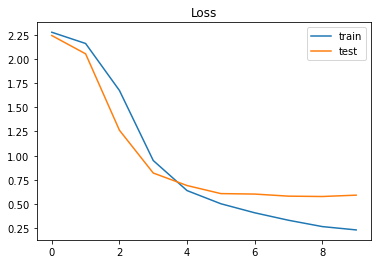

In [24]:
plt.title('Loss')
plt.plot(models.history['loss'], label='train')
plt.plot(models.history['val_loss'], label='test')
plt.legend()
plt.show()

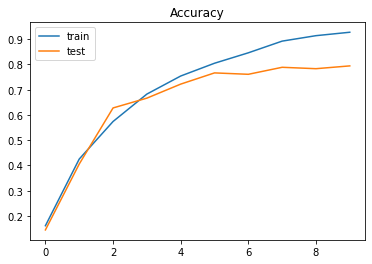

In [25]:
plt.title('Accuracy')
plt.plot(models.history['accuracy'], label='train')
plt.plot(models.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [26]:
accuracy = model.evaluate(X_test,Y_test)
#print('Test set\nLoss: {}\nAccuracy: {}'.format(accuracy[0],accuracy[1]))
print('Test set\nLoss: {:0.5f}\nAccuracy: {:0.5f}'.format(accuracy[0],accuracy[1]))

200/200 [==============================] - 0s 1ms/step
Test set
Loss: 0.48363
Accuracy: 0.78000


# Evaluation

In [34]:
# preprocess test data

yhat = model.predict(X_test, verbose=0)
preds_labels = [[1 if x > 0.5 else 0 for idx,x in enumerate(i) ] for i in yhat]

In [37]:
print(multilabel_confusion_matrix(Y_test, preds_labels))

[[[167   9]
  [  8  16]]

 [[188   3]
  [  1   8]]

 [[175   5]
  [  4  16]]

 [[173   8]
  [  1  18]]

 [[177   0]
  [  0  23]]

 [[168   8]
  [ 12  12]]

 [[182   0]
  [  4  14]]

 [[181   0]
  [  0  19]]

 [[176   4]
  [  8  12]]

 [[174   2]
  [  9  15]]]


In [38]:
#print(average_precision_score(y_test, preds_labels))
#print(f1_score(y_test, preds_labels, average='micro'))
print('ROC-AUC Score:', roc_auc_score(Y_test, preds_labels))

ROC-AUC Score: 0.8793920753810536


# ----- Just for fun -----

In [27]:

# Test with new text description

TEXT = ["He is wearing a dark blue t-shirt"]

In [28]:
new_description = TEXT
seq = tokenizer.texts_to_sequences(new_description)
padded = pad_sequences(seq, maxlen=MAX_LENGTH)
pred = model.predict(padded)

In [29]:
labels = fashion_df.category.unique().tolist()
labels

['women dresses',
 'women skirts',
 'men outwear',
 'men tops',
 'women outwear',
 'men trousers',
 'women trousers',
 'women shorts',
 'men shorts',
 'women tops']

In [30]:
print(pred)
print(labels[np.argmax(pred)])

[[1.4612759e-03 6.1752261e-03 9.1611296e-01 1.3927783e-02 2.5608917e-04
  1.3329446e-03 1.0454543e-03 3.5903510e-04 3.5836592e-02 2.3492761e-02]]
men outwear


# ----- END -----